<a href="https://colab.research.google.com/github/ewst22ParkSY/ESAA11_YB/blob/ESAA11_YB/YB_3%EC%A1%B0_%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123630 files and direc

In [4]:
# 지수 표기법 대신 float 형식으로 출력
pd.set_option('display.float_format', '{:.2f}'.format)

#**1. 데이터 불러오기 및 결측치 처리**

In [5]:
movie_train = pd.read_csv('/content/drive/MyDrive/미니 프로젝트 3/movies_train.csv')
movie_test = pd.read_csv("/content/drive/MyDrive/미니 프로젝트 3/movies_test.csv")

In [6]:
# 새로고침을 위해 복사본 생성
train_df = movie_train.copy()
test_df = movie_test.copy()

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


# **2. 전처리**

## 2.1 결측값 처리
- 전체 피처 중 dir_prev_bfnum 피처만 총 600개 데이터 중 330개가 결측치임. 0으로 채워줌.

In [9]:
# 결측치 처리
if (train_df['dir_prev_bfnum'].isnull().any()) & (train_df['dir_prev_num'].isnull().sum() == 0):
  train_df['dir_prev_bfnum'] = train_df['dir_prev_bfnum'].fillna(0)

if (test_df['dir_prev_bfnum'].isnull().any()) & (test_df['dir_prev_num'].isnull().sum() == 0):
  test_df['dir_prev_bfnum'] = test_df['dir_prev_bfnum'].fillna(0)

## 2.2 칼럼별 전처리

### 2.2.0 title: 영화제목

In [10]:
# train_df.drop('title', axis=1, inplace=True)
# test_df.drop('title', axis=1, inplace=True)

### 2.2.1 distributor : 배급사
- distributor 별 box_off_num 평균으로 랭킹 인코딩을 시도했는데, 그냥 원핫인코딩했을 때보다 개선을 보임. 채택.

In [11]:
train_df['distributor'] = train_df['distributor'].str.replace("(주)","")
train_df['distributor'] = train_df['distributor'].str.replace(" ","")

test_df['distributor'] = test_df['distributor'].str.replace("(주)","")
test_df['distributor'] = test_df['distributor'].str.replace(" ","")

In [12]:
distributor = train_df['distributor'].value_counts()

def distributor_func(distributor):
  if 'CGV' in distributor:
    return 'CGV'
  elif 'E&M'in distributor or 'CJ엔터테인먼트' in distributor:
    return 'CJ'
  elif '마운틴' in distributor:
    return '마운틴픽처스'
  elif '쇼박스' in distributor:
    return '쇼박스'
  elif 'NEW' in distributor or '넥스트' in distributor:
    return 'NEW(넥스트엔터테인먼트월드)'
  else:
    return distributor

In [13]:
# 배급사 distributor 의 box_off_num 평균 기준으로 랭킹 인코딩
# 1. 배급사별 평균 관객수 계산
distributor_avg = train_df.groupby('distributor')['box_off_num'].mean()

# 2. 배급사별 평균 관객수 기준으로 순위 매기기
distributor_rank = distributor_avg.sort_values(ascending=False).rank(method='min', ascending=False)

# 3. 각 영화의 배급사에 해당하는 순위를 원본 데이터에 매핑
train_df['distributor_rank'] = train_df['distributor'].map(distributor_rank)

# 4. test_df에 train_df에서 계산한 rank 매핑
test_df['distributor_rank'] = test_df['distributor'].map(distributor_rank)

# 5. test_df에 없는 배급사 처리 (기본값 설정)
# 기본값을 NaN으로 처리하거나 특정 값(예: 0 또는 가장 낮은 순위)으로 대체
test_df['distributor_rank'] = test_df['distributor_rank'].fillna(distributor_rank.max() + 1)

In [14]:
# 원해 배급사 피처 삭제
train_df.drop(['distributor'], axis=1, inplace=True)
# train_df.drop(['distributor_count'], axis=1, inplace=True)

###2.2.2 genre: 장르
- 배급사와는 다르게 genre 별 box_off_num 평균으로 랭킹 인코딩을 시도했으나 그냥 원핫인코딩했을 때가 나았음.

In [15]:
# 장르 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['genre'] = le.fit_transform(train_df['genre'])
test_df['genre'] = le.transform(test_df['genre'])

onehot = OneHotEncoder(sparse_output=False)
genre_oh = onehot.fit_transform(train_df[['genre']])
train_encoded_df = pd.DataFrame(genre_oh,
                                columns=[f'genre_{int(cat)}' for cat in onehot.categories_[0]])

genre_oh2 = onehot.transform(test_df[['genre']])
test_encoded_df = pd.DataFrame(genre_oh2,
                               columns=[f'genre_{int(cat)}' for cat in onehot.categories_[0]])

# 원래 데이터프레임과 합치기
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

### 2.2.3 release_time: 개봉일
- season(계절), year(연도)를 개봉일에서 분리해냄.
- 뒤에 새로운 피처 생성할 때 season이 사용되므로 일단은 year만 드랍.

In [16]:
train_df['season'] =0
test_df['season'] =0
train_df['year'] = train_df['release_time'].apply(lambda x: x.split('-')[0])
test_df['year'] = test_df['release_time'].apply(lambda x: x.split('-')[0])
train_df['month'] = train_df['release_time'].apply(lambda x: int(x.split('-')[1]))
test_df['month'] = test_df['release_time'].apply(lambda x: int(x.split('-')[1]))

def season_func(month):
  if month in [3,4,5]:
    return '봄'
  elif month in [6,7,8]:
    return '여름'
  elif month in [9,10,11]:
    return '가을'
  else:
    return '겨울'

train_df['season'] = train_df['month'].apply(season_func)
test_df['season'] = test_df['month'].apply(season_func)

In [17]:
# 계절 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['season'] = le.fit_transform(train_df['season'])
test_df['season'] = le.transform(test_df['season'])

onehot = OneHotEncoder(sparse_output=False)
season_n = onehot.fit_transform(train_df[['season']])
train_encoded_df = pd.DataFrame(season_n,
                                columns=[f'season_{int(cat)}' for cat in onehot.categories_[0]])

season_n2 = onehot.transform(test_df[['season']])
test_encoded_df = pd.DataFrame(season_n2,
                               columns=[f'season_{int(cat)}' for cat in onehot.categories_[0]])

# 원래 데이터프레임과 합치기
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

In [19]:
# year도 범주형이므로 원핫 인코딩
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['year'] = le.fit_transform(train_df['year'])
test_df['year'] = le.transform(test_df['year'])

onehot = OneHotEncoder(sparse_output=False)
year_n = onehot.fit_transform(train_df[['year']])
train_encoded_df = pd.DataFrame(year_n,
                                columns=[f'year_{int(cat)}' for cat in onehot.categories_[0]])

year_n2 = onehot.transform(test_df[['year']])
test_encoded_df = pd.DataFrame(year_n2,
                               columns=[f'year_{int(cat)}' for cat in onehot.categories_[0]])

# 원래 데이터와 합치기
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)


In [20]:
# year은 드롭
train_df.drop('year', axis=1, inplace=True)
test_df.drop('year', axis=1, inplace=True)

### 2.2.4 time: 상영시간(분)
- skewness가 0.75 이하이므로 로그변환 안 함.

In [21]:
from scipy.stats import skew

skew(train_df['time'])

0.3447840297735809

### 2.2.5 screening_rat: 상영등급
- 단순 원핫 인코딩

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['screening_rat'] = le.fit_transform(train_df['screening_rat'])
test_df['screening_rat'] = le.transform(test_df['screening_rat'])

onehot = OneHotEncoder(sparse_output=False)
screening_rat_oh = onehot.fit_transform(train_df[['screening_rat']])
train_encoded_df = pd.DataFrame(screening_rat_oh,
                                columns=[f'screening_rat_{int(cat)}' for cat in onehot.categories_[0]])

screening_rat_oh2 = onehot.transform(test_df[['screening_rat']])
test_encoded_df = pd.DataFrame(screening_rat_oh2,
                               columns=[f'screening_rat_{int(cat)}' for cat in onehot.categories_[0]])

# 원래 데이터와 합치기
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

### *새로운 피처 시도
- 배경정보: 보통 장르, 상영등급, 예산, 배급사가 제일 중요한 역할을 함. 뒤에 회귀 계수 시각화해봤을 때도 장르, 상영등급이 높은 계수를 가짐을 알 수 있음.
- 장르 + 상영등급, box_off_num 평균으로 랭킹 인코딩 (별로)
- 겨울엔 드라마/로맨스, 여름엔 호러가 인기가 많지 않을까? (그래프도 그려보면 좋을 듯)

   --> 장르 + 계절, box_off_num 평균으로 랭킹 인코딩 (채택)

In [23]:
# 장르와 계절을 결합하여 box_off_num 평균 기준으로 랭킹 인코딩

train_df['genre_season'] = train_df['genre'].astype(str) + "_" + train_df['season'].astype(str)
test_df['genre_season'] = test_df['genre'].astype(str) + "_" + test_df['season'].astype(str)

# 장르+계절별 평균 관객수 계산
genre_season_avg = train_df.groupby('genre_season')['box_off_num'].mean()

# 장르+계절별 평균 관객수 기준으로 순위 매기기
genre_season_rank = genre_season_avg.sort_values(ascending=False).rank(method='min', ascending=False)

# 각 영화의 장르+계절 조합에 해당하는 순위를 원본 데이터에 매핑
train_df['genre_season_rank'] = train_df['genre_season'].map(genre_season_rank)
test_df['genre_season_rank'] = test_df['genre_season'].map(genre_season_rank)

# test_df에 없는 genre_season 처리 (기본값 설정)
# 기본값: 가장 낮은 순위 + 1
test_df['genre_season_rank'] = test_df['genre_season_rank'].fillna(genre_season_rank.max() + 1)

train_df.drop(['genre_season'], axis=1, inplace=True)
test_df.drop(['genre_season'], axis=1, inplace=True)

### 2.2.6 director: 감독이름

In [24]:
train_df['director'].value_counts()

,count
director,
홍상수,7
장률,4
신재호,4
우민호,4
노진수,4
...,...
권오광,1
한윤선,1
박찬경,1


### 2.2.7 dir_prev_num: 감독의 이전 영화 참여 개수
- 0값이 절반 이상인 330개를 차지. 감독의 이전 영화 참여 개수를 알 수 없는 데이터가 330개라는 뜻.
- 3개 이상 영화 낸 감독들에 관해서만 오류 확인해봄(3개 이상부터는 이전 작품의 관객수 중요)
   - 오류: 홍상수, 장률, 신재호(하나씩 밀림), 노진수, 전규환, 전수일, 신연식,박철수, 오멸, 김기덕, 장진, 권칠인, 조성규, 김현석, 김조광수, 김봉은, 윤여창, 정성복, 조조 히데오
   - 잘된 사람: 우민호, 김현석

- 영화 1-2개만 기입되어 있으나 관객수 합계는 상위권인 감독 (30.00 이상)
   - 최동훈, 이석훈, 강형철, 김지훈: 다 dir_prev_bfnum 잘 기입되어 있음! 희소식
   - 오류발견: 추창민, 류승완
- 주어진 데이터에서 영화 개수가 7개일 경우 개봉일 순서대로 차례대로 0, 1, 2...6값을 갖도록 수정. 안타깝게도 0인 것만 수정하면 이미 존재하는 숫자와 겹치므로 전체 데이터를 수정.

In [25]:
train_df[train_df['dir_prev_num']==0]

,title,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,...,year_1,year_2,year_3,year_4,year_5,screening_rat_0,screening_rat_1,screening_rat_2,screening_rat_3,genre_season_rank
0,개들의 전쟁,10,2012-11-22,96,3,조병옥,0.00,0,91,2,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,13.00
6,길위에서,3,2013-05-23,104,2,이창재,0.00,0,32,5,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,38.00
8,"1789, 바스티유의 연인들",6,2014-09-18,129,2,정성복,0.00,0,3,5,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,39.00
9,청춘그루브,4,2012-03-15,94,1,변성현,0.00,0,138,3,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,27.00
10,AV 아이돌,5,2015-07-27,89,3,조조 히데오,0.00,0,0,4,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,29.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,낭만파 남편의 편지,7,2013-09-12,97,3,최위안,0.00,0,5,3,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,14.00
594,오빠가 돌아왔다,11,2014-03-20,94,3,노진수,0.00,0,37,5,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,10.00
597,살인의 강,1,2010-09-30,99,3,김대현,0.00,0,123,4,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,18.00
598,악의 연대기,2,2015-05-14,102,1,백운학,0.00,0,431,4,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,12.00


In [26]:
train_df[train_df['director']=='홍상수']

,title,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,...,year_1,year_2,year_3,year_4,year_5,screening_rat_0,screening_rat_1,screening_rat_2,screening_rat_3,genre_season_rank
15,자유의 언덕,4,2014-09-04,67,3,홍상수,0.00,0,52,3,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,20.00
19,하하하,4,2010-05-05,115,3,홍상수,0.00,0,74,9,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00
115,북촌방향,4,2011-09-08,79,3,홍상수,0.00,0,55,5,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
164,지금은맞고그때는틀리다,4,2015-09-24,121,3,홍상수,39317.00,1,16,2,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,20.00
331,다른나라에서,4,2012-05-31,89,3,홍상수,0.00,0,70,2,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00
506,우리 선희,4,2013-09-12,89,3,홍상수,0.00,0,8,6,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
523,옥희의 영화,4,2010-09-16,80,3,홍상수,0.00,0,57,3,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00


In [27]:
# <전체 정렬>
# 개봉일을 datetime 형식으로 변환
train_df['release_time'] = pd.to_datetime(train_df['release_time'])

# 개봉일 기준으로 정렬
train_df = train_df.sort_values('release_time').reset_index(drop=True)

# 감독별 이전 영화 개수 계산
train_df['dir_prev_num'] = train_df.groupby('director').cumcount()

In [28]:
train_df[train_df['director']=='홍상수']

,title,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,...,year_1,year_2,year_3,year_4,year_5,screening_rat_0,screening_rat_1,screening_rat_2,screening_rat_3,genre_season_rank
25,하하하,4,2010-05-05,115,3,홍상수,0.00,0,74,9,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00
59,옥희의 영화,4,2010-09-16,80,3,홍상수,0.00,1,57,3,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
145,북촌방향,4,2011-09-08,79,3,홍상수,0.00,2,55,5,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
206,다른나라에서,4,2012-05-31,89,3,홍상수,0.00,3,70,2,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00
318,우리 선희,4,2013-09-12,89,3,홍상수,0.00,4,8,6,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
432,자유의 언덕,4,2014-09-04,67,3,홍상수,0.00,5,52,3,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,20.00
556,지금은맞고그때는틀리다,4,2015-09-24,121,3,홍상수,39317.00,6,16,2,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,20.00


### 2.2.8 dir_prev_bfnum: 감독의 이전 영화 평균 관객수
- 이전에 결측치였던 330개의 값들을 0으로 채워줬었음.
- 이 0값들을 어떻게 채울것인가? (이렇게 해도 되나)
   - sol1) 위의 dir_prev_num를 이용해서 특정 시점 전까지 개봉한 영화들의 box_off_num의 평균을 구하여 차례대로 업데이트하기
   - sol2) 감독별로 box_off_num의 평균으로 다 똑같이 채우기
- sol2가 더 mse값 작았음. sol2 채택.
- 이미 채워져있던 데이터는 냅둠. 0인 것만 수정. (0인 것만 수정했을 때 성능이 더 좋았음.)

In [29]:
train_df[train_df['dir_prev_bfnum']==0]

,title,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,...,year_1,year_2,year_3,year_4,year_5,screening_rat_0,screening_rat_1,screening_rat_2,screening_rat_3,genre_season_rank
0,카페 서울,4,2010-01-02,94,0,타케 마사하루,0.00,0,41,2,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00
1,소규모 아카시아 밴드 이야기,3,2010-01-14,90,0,민환기,0.00,0,18,7,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,36.00
3,페어 러브,4,2010-01-14,117,0,신연식,0.00,0,106,2,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,9.00
4,회복,3,2010-01-14,94,0,김종철,0.00,0,54,1,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,36.00
6,사사건건,4,2010-01-21,91,3,이정욱,0.00,0,148,8,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,뽀로로 극장판 컴퓨터 왕국 대모험,9,2015-12-10,62,2,박영균,0.00,0,2,8,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,24.00
592,"실론, 세렌디피티",4,2015-12-14,108,1,권중목,0.00,0,23,2,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,9.00
595,인 허 플레이스,4,2015-12-17,115,3,알버트 신,0.00,0,28,3,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,9.00
596,굿바이 그리고 헬로우,4,2015-12-24,82,0,한창근,0.00,0,23,4,...,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,9.00


In [30]:
# # <0인 것만 감독의 이전 영화 참여 개수 피처를 이용해서 전까지 개봉한 영화의 box_off_num의 평균을 구하여 차례대로 업데이트하기>
# # 개봉일 기준 정렬
# train_df = train_df.sort_values('release_time').reset_index(drop=True)

# # `dir_prev_bfnum`이 0인 경우에만 이전 영화 평균 관객수 업데이트
# for director in train_df['director'].unique():
#     # 감독별 데이터 가져오기
#     director_movies = train_df[train_df['director'] == director]

#     # 감독의 이전 영화 평균 관객수 계산
#     cumulative_avg = []
#     for i, row in director_movies.iterrows():
#         # dir_prev_bfnum이 0인 경우에만 업데이트
#         if row['dir_prev_bfnum'] == 0:
#             # 이전 영화의 관객수 평균을 계산
#             previous_movies = director_movies[director_movies['release_time'] < row['release_time']]
#             avg_box_off = previous_movies['box_off_num'].mean() if not previous_movies.empty else 0
#             cumulative_avg.append(avg_box_off)
#         else:
#             # 이미 값이 채워져 있는 경우 그대로 유지
#             cumulative_avg.append(row['dir_prev_bfnum'])

#     # 계산된 평균 값으로 업데이트
#     train_df.loc[director_movies.index, 'dir_prev_bfnum'] = cumulative_avg

In [31]:
# <0인 것만 감독별 box_off_num의 평균으로 채우기>
# 감독별 평균 관객수를 데이터프레임에 추가

director_stats = train_df.groupby('director').agg(
    total_audience=('box_off_num', 'sum'),  # 총 관객수 합
    movie_count=('title', 'count')  # 영화 개수
)

# 감독별 평균 관객수 계산 (총 관객수의 합 / 영화 개수)
director_stats['avg_audience'] = director_stats['total_audience'] / director_stats['movie_count']

train_df = train_df.merge(director_stats[['avg_audience']], on='director', how='left')

# dir_prev_bfnum이 0인 경우, 감독별 평균 관객수로 채움
train_df.loc[train_df['dir_prev_bfnum'] == 0, 'dir_prev_bfnum'] = train_df['avg_audience']

# 필요 없는 avg_audience 열 제거 (선택사항)
train_df = train_df.drop(columns=['avg_audience'])

In [32]:
train_df[train_df['director']=='홍상수']

,title,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,...,year_1,year_2,year_3,year_4,year_5,screening_rat_0,screening_rat_1,screening_rat_2,screening_rat_3,genre_season_rank
25,하하하,4,2010-05-05,115,3,홍상수,51519.57,0,74,9,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00
59,옥희의 영화,4,2010-09-16,80,3,홍상수,51519.57,1,57,3,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
145,북촌방향,4,2011-09-08,79,3,홍상수,51519.57,2,55,5,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
206,다른나라에서,4,2012-05-31,89,3,홍상수,51519.57,3,70,2,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00
318,우리 선희,4,2013-09-12,89,3,홍상수,51519.57,4,8,6,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,20.00
432,자유의 언덕,4,2014-09-04,67,3,홍상수,51519.57,5,52,3,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,20.00
556,지금은맞고그때는틀리다,4,2015-09-24,121,3,홍상수,39317.00,6,16,2,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,20.00


### 2.2.9 num_staff: 스텝 수
- 왜곡도가 0.75 이상이므로 로그변환 해주기

In [33]:
skew(train_df['num_staff'])

1.2303665582484264

In [34]:
train_df['num_staff'] = np.log1p(train_df['num_staff'])

In [35]:
test_df['num_staff'] = np.log1p(test_df['num_staff'])

### 2.2.10 num_actor: 주연배우 수
- 왜곡도가 0.75 이상이므로 로그변환 해주기

In [36]:
skew(train_df['num_actor'])

2.943286008621123

In [37]:
train_df['num_actor'] = np.log1p(train_df['num_actor'])

In [38]:
test_df['num_actor'] = np.log1p(test_df['num_actor'])

### 2.2.11 box_off_num: 관객 수 (**타깃값**)
- 왜곡도가 0.75 이상이므로 로그변환 해주기. 정규분포 형태를 띄는 것이 중요한 타깃피처.

In [39]:
skew(train_df['box_off_num'])

4.321279878093952

In [40]:
train_df['box_off_num'] = np.log1p(train_df['box_off_num'])

## 2.3 불필요한 피처 삭제
- 문자형인 director, title 삭제
- 원핫 인코딩한 genre, season 삭제
- season에 사용된 month 삭제
- season, year 등의 필요한 정보 추출했다고 판단한 release_time 삭제
- dir_prev_bfnum, dir_prev_num 0이 너무 많아서 아예 삭제하는게 나을까해서 시도해봤는데 그래도 있는게 나았음.

In [41]:
train_df.drop(['director', 'title'] , axis=1, inplace=True)

In [42]:
train_df = train_df.drop(['month'], axis=1)
test_df = test_df.drop(['month'], axis=1)

In [43]:
train_df = train_df.drop(['release_time'], axis=1)
test_df = test_df.drop(['release_time'], axis=1)

In [44]:
train_df.drop(['genre'], axis=1, inplace=True)
test_df.drop(['genre'], axis=1, inplace=True)

In [45]:
# season 칼럼 드랍
train_df.drop('season', axis=1, inplace=True)
test_df.drop('season', axis=1, inplace=True)

In [46]:
test_df.drop(['title', 'director', 'distributor'], axis=1, inplace=True)

##2.4 최종 데이터 확인
- train_df랑 test_df가 타깃 피처를 제외하고 동일한 피처들을 가져야하는거...맞죠?
- 전처리 이전 피처 개수 12개 -> 이후 35개  

In [47]:
movie_train_cleaned = train_df.copy()

In [48]:
movie_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               600 non-null    int64  
 1   screening_rat      600 non-null    int64  
 2   dir_prev_bfnum     600 non-null    float64
 3   dir_prev_num       600 non-null    int64  
 4   num_staff          600 non-null    float64
 5   num_actor          600 non-null    float64
 6   box_off_num        600 non-null    float64
 7   distributor_rank   600 non-null    float64
 8   genre_0            600 non-null    float64
 9   genre_1            600 non-null    float64
 10  genre_2            600 non-null    float64
 11  genre_3            600 non-null    float64
 12  genre_4            600 non-null    float64
 13  genre_5            600 non-null    float64
 14  genre_6            600 non-null    float64
 15  genre_7            600 non-null    float64
 16  genre_8            600 non

In [49]:
movie_test_cleaned = test_df.copy()
movie_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               243 non-null    int64  
 1   screening_rat      243 non-null    int64  
 2   dir_prev_bfnum     243 non-null    float64
 3   dir_prev_num       243 non-null    int64  
 4   num_staff          243 non-null    float64
 5   num_actor          243 non-null    float64
 6   distributor_rank   243 non-null    float64
 7   genre_0            243 non-null    float64
 8   genre_1            243 non-null    float64
 9   genre_2            243 non-null    float64
 10  genre_3            243 non-null    float64
 11  genre_4            243 non-null    float64
 12  genre_5            243 non-null    float64
 13  genre_6            243 non-null    float64
 14  genre_7            243 non-null    float64
 15  genre_8            243 non-null    float64
 16  genre_9            243 non

In [50]:
print(movie_train.shape, movie_train_cleaned.shape)

(600, 12) (600, 35)


## 2.5 회귀 피팅 후 회귀계수 확인
- 일반선형, 릿지에선 genre_8, screen_rat_2, genre_1 등이 중요한 피처였음.
- 라쏘에선 time, genre_season_rank, distributor_ranking을 제외한 모든 피처계수값이 0. (?)

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

# movie_train_cleaned['release_time_timestamp'] = movie_train_cleaned['release_time'].astype(int)
# movie_train_cleaned.drop('release_time', axis = 1, inplace = True)

X = movie_train_cleaned.drop('box_off_num', axis = 1)
y = movie_train_cleaned['box_off_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               243 non-null    int64  
 1   screening_rat      243 non-null    int64  
 2   dir_prev_bfnum     243 non-null    float64
 3   dir_prev_num       243 non-null    int64  
 4   num_staff          243 non-null    float64
 5   num_actor          243 non-null    float64
 6   distributor_rank   243 non-null    float64
 7   genre_0            243 non-null    float64
 8   genre_1            243 non-null    float64
 9   genre_2            243 non-null    float64
 10  genre_3            243 non-null    float64
 11  genre_4            243 non-null    float64
 12  genre_5            243 non-null    float64
 13  genre_6            243 non-null    float64
 14  genre_7            243 non-null    float64
 15  genre_8            243 non-null    float64
 16  genre_9            243 non

In [53]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 회귀 계수 값의 상위 10개, 하위 10개의 피처명과 그 회귀계수 값을 가지는 Series 객체를 반화하는 함수 생성
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
  coef = pd.Series(model.coef_, index=X_train.columns)

  # + 상위 10개, - 하위 10개의 회귀계수를 추출해서 반환
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

# 모델 별로 회귀 계수 시각화하기
def visualize_coefficient(models):
  # 3개의 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
  fig.tight_layout()
  # 입력 인자로 받은 list 객체인 models에 서 차례로 model을 추출해 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
    axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
    axs[i_num].tick_params(axis='y', direction='in', pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# # 앞 예제에서 학습한 ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
# def get_avg_rmse_cv(models):
#   for model in models:
#     # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE 값과 평균 RMSE 출력
#     rmse_list = np.sqrt(-cross_val_score(model, X_train, y_train,
#                                         scoring='neg_mean_squared_error', cv=5))
#     rmse_avg = np.mean(rmse_list)
#     print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# cross_val_score이 아닌 단순 RMSE값
def rmse(models):
    for model in models:
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print('\n{0} RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse, 3)))

# kfold, cross_val_score을 이용한 RMSE 값
n_folds = 5
def rmsle_cv(model):
  # get_n_splits() returns the number of folds (n_folds).
  kf = KFold(n_folds, shuffle=True, random_state=42)
  rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                  scoring='neg_mean_squared_error', cv=kf))
  rmse = rmse.mean()
  print(f"훈련 데이터에서의 평균 RMSE (교차 검증): {rmse:.3f}")

  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
  rmse_test = rmse_test.mean()
  print(f"테스트 데이터에서의 RMSE: {rmse_test:.3f}")


훈련 데이터에서의 평균 RMSE (교차 검증): 1.834
테스트 데이터에서의 RMSE: 1.577
None
훈련 데이터에서의 평균 RMSE (교차 검증): 1.828
테스트 데이터에서의 RMSE: 1.574
None
훈련 데이터에서의 평균 RMSE (교차 검증): 1.850
테스트 데이터에서의 RMSE: 1.636
None


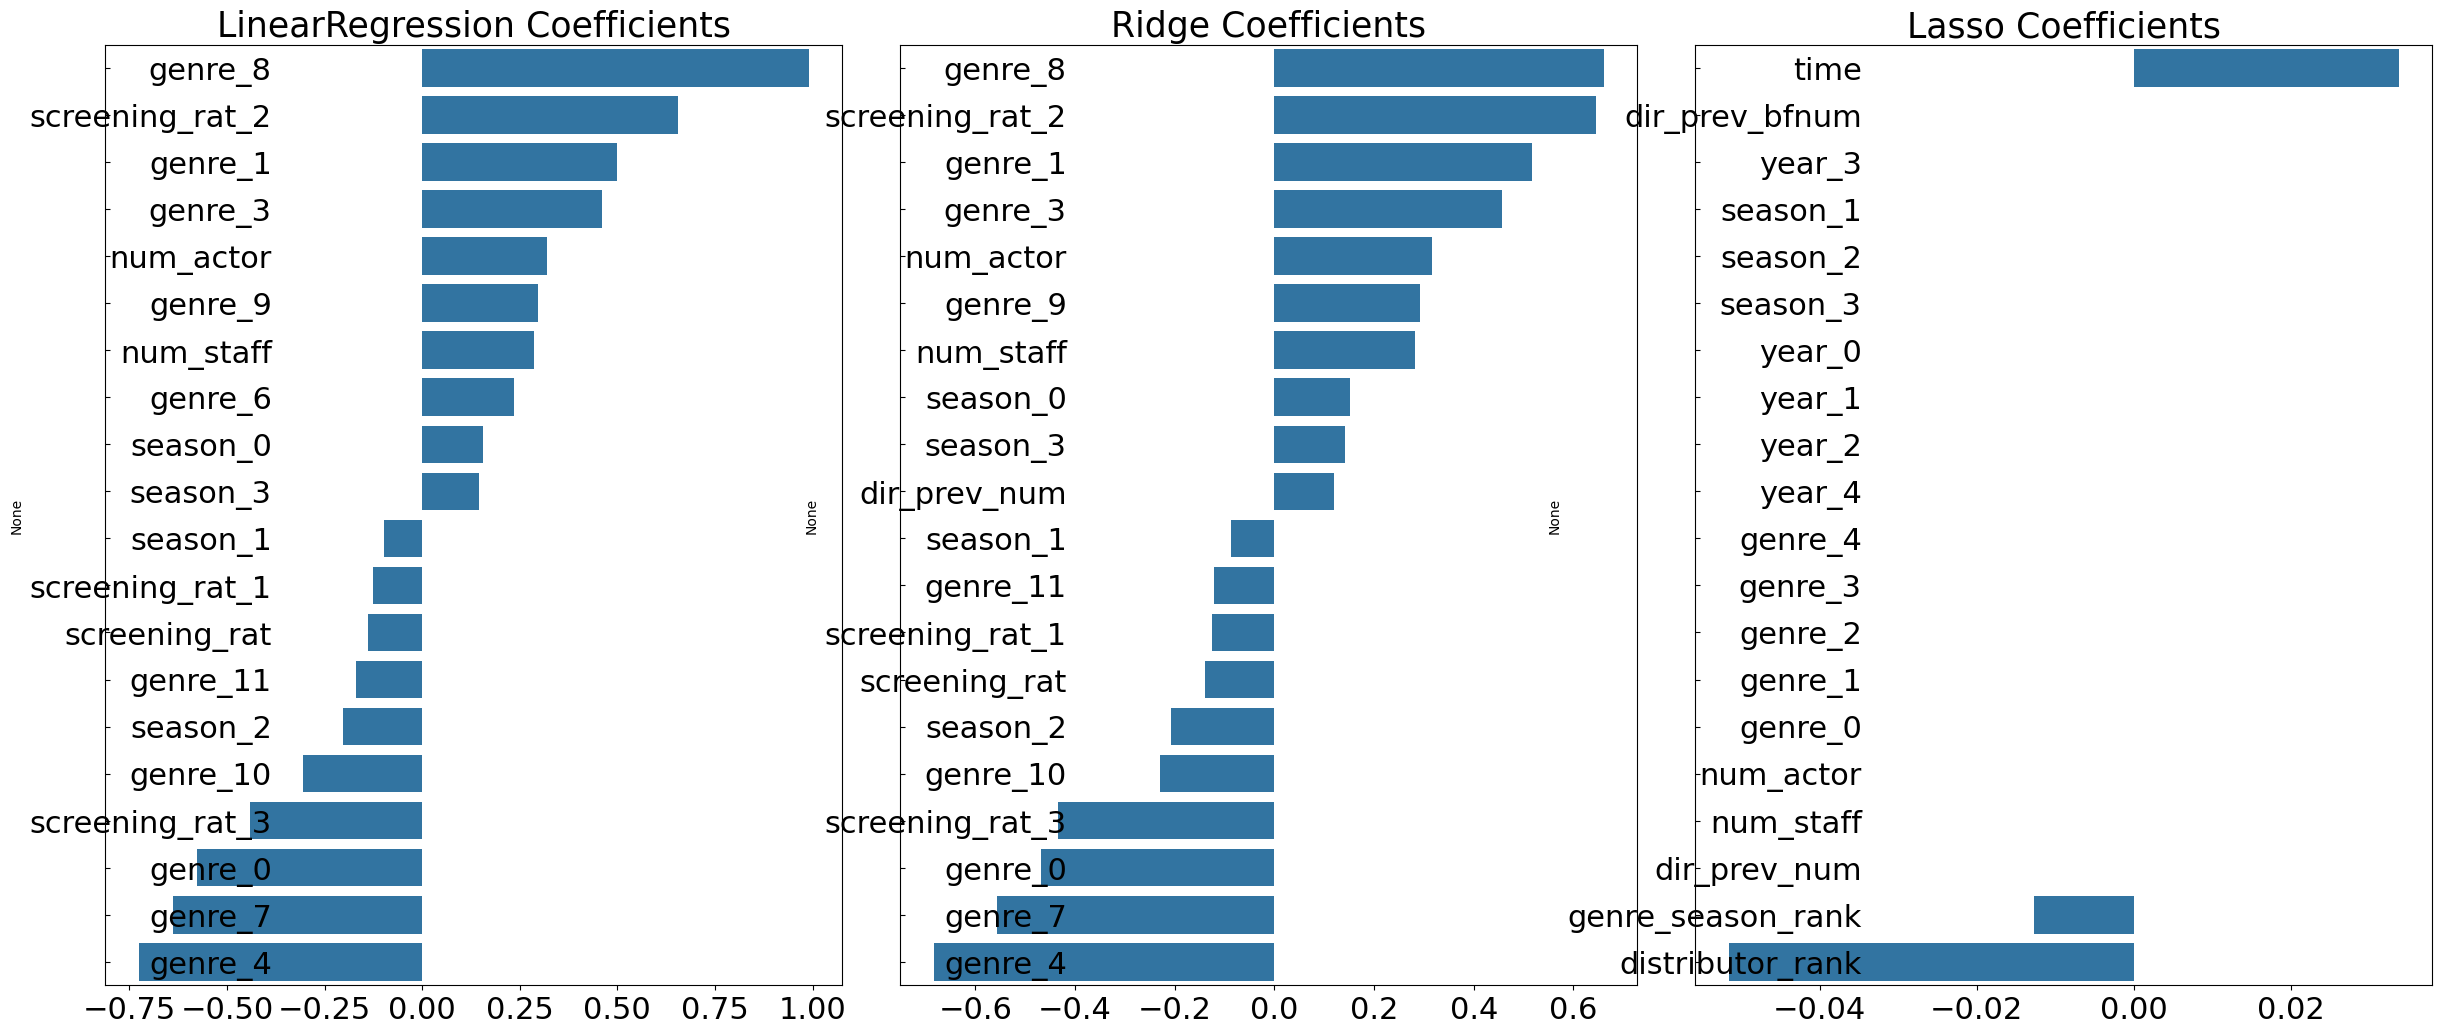

In [54]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)
print(rmsle_cv(lr_reg))
print(rmsle_cv(ridge_reg))
print(rmsle_cv(lasso_reg))

## 2.6 숫자형 (회귀계수가 높은) 피처의 이상치 제거
- 이상치 처리를 어떻게 하는게 좋을까?
   - 미디언으로 대체, 평균으로 대체, 아예 삭제, time은 삭제 num_actor은 평균으로 대체하는 방법들 시도
   - 평균으로 대체했을 때가 미디언으로 대체했을 때보다 미묘하게 나았음. 미디언 채택.

In [55]:
def calculate_outlier_ratio(df, column):
    # 1사분위수 (Q1)과 3사분위수 (Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # IQR 계산
    IQR = Q3 - Q1

    # 이상치 기준 값 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 이상치 데이터 필터링
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # 이상치 비율 계산
    outlier_ratio = len(outliers) / len(df)

    return outlier_ratio

# 'num_staff'와 'time'에 대한 이상치 비율 계산
num_staff_outlier_ratio = calculate_outlier_ratio(train_df, 'num_staff')
time_outlier_ratio = calculate_outlier_ratio(train_df, 'time')
num_actor_outlier_ratio = calculate_outlier_ratio(train_df, 'num_actor')


# 결과 출력
print(f"time의 이상치 비율: {time_outlier_ratio:.2%}")
print(f"num_staff의 이상치 비율: {num_staff_outlier_ratio:.2%}")
print(f"num_actor의 이상치 비율: {num_actor_outlier_ratio:.2%}")


time의 이상치 비율: 1.00%
num_staff의 이상치 비율: 0.00%
num_actor의 이상치 비율: 4.67%


In [56]:
# 이상치를 평균으로 대체
def replace_outliers_with_mean(df, columns):
    for col in columns:
        # Q1, Q3, IQR 계산
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # 이상치 범위 설정 (이 범위를 벗어난 값은 이상치)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 이상치를 평균값으로 대체
        mean_value = df[col].mean()
        df[col] = df[col].apply(lambda x: mean_value if x < lower_bound or x > upper_bound else x)

    return df


train_df = replace_outliers_with_mean(train_df, ['time', 'num_staff', 'num_actor'])
movie_train_cleaned = train_df.copy()
X = movie_train_cleaned.drop('box_off_num', axis = 1)
y = movie_train_cleaned['box_off_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
print(rmsle_cv(lr_reg))
print(rmsle_cv(ridge_reg))
print(rmsle_cv(lasso_reg))

훈련 데이터에서의 평균 RMSE (교차 검증): 1.823
테스트 데이터에서의 RMSE: 1.564
None
훈련 데이터에서의 평균 RMSE (교차 검증): 1.818
테스트 데이터에서의 RMSE: 1.561
None
훈련 데이터에서의 평균 RMSE (교차 검증): 1.845
테스트 데이터에서의 RMSE: 1.630
None


# Modeling

movie_train_cleaned.info()

In [57]:
X = movie_train_cleaned.drop('box_off_num', axis = 1)
y = movie_train_cleaned['box_off_num']

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

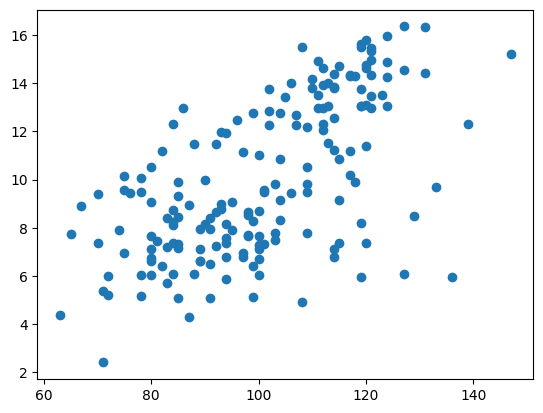

In [60]:
plt.scatter(X_test['time'], y_test)
plt.show()

##Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(X_train, y_train)

linear_pred = linear.predict(X_test)

linear_MSE = mean_squared_error(y_test, linear_pred)
print(np.round(np.sqrt(linear_MSE), 3))

1.564


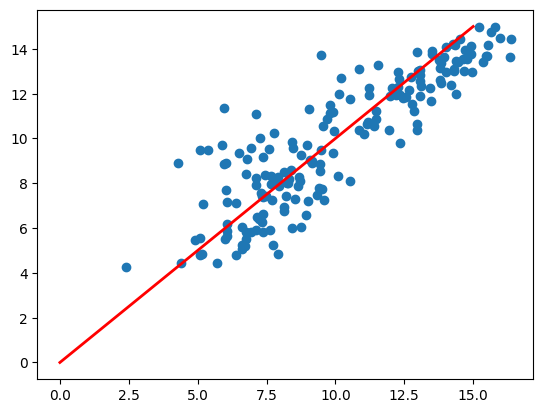

In [62]:
plt.scatter(y_test, linear_pred)
plt.plot([0, 15], [0, 15], color='red', linewidth=2)
plt.show()

###Polynomial Regression

In [63]:
from sklearn.preprocessing import PolynomialFeatures

degrees = [2, 3, 4]
for degree in degrees:
  poly = PolynomialFeatures(degree = degree)
  poly.fit(X)
  X_poly = poly.transform(X)

  X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size = 0.2, random_state = 1)

  polylinear = LinearRegression()
  polylinear.fit(X_train_poly, y_train_poly)

  poly_pred = polylinear.predict(X_test_poly)

  poly_MSE = mean_squared_error(y_test_poly, poly_pred)
  print('degree: {0}, RMSE: {1}'.format(degree, np.round(np.sqrt(poly_MSE), 3)))

degree: 2, RMSE: 3.975
degree: 3, RMSE: 184.056
degree: 4, RMSE: 295.9


In [64]:
#best model

poly = PolynomialFeatures(degree = 2)
poly.fit(X)
X_poly = poly.transform(X)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size = 0.2, random_state = 1)

polylinear = LinearRegression()
polylinear.fit(X_train_poly, y_train_poly)

poly_pred = polylinear.predict(X_test_poly)

poly_MSE = mean_squared_error(y_test_poly, poly_pred)
print(np.round(np.sqrt(poly_MSE), 3))

3.975


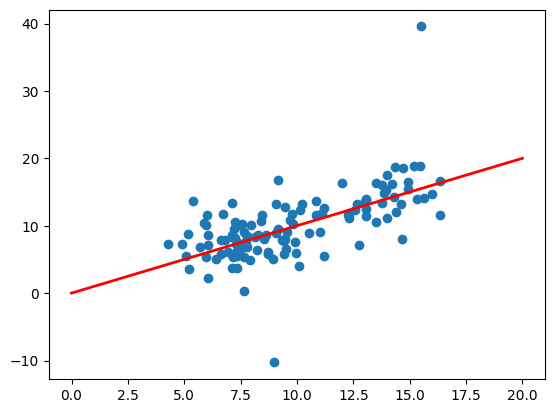

In [65]:
plt.scatter(y_test_poly, poly_pred)
plt.plot([0, 20], [0, 20], color='red', linewidth=2)

plt.show()

### Regularization Regression

####L2:Ridge

In [66]:
from sklearn.linear_model import Ridge

In [67]:
alphas = [0, 0.1, 0.5, 1, 3, 5, 7, 9, 10, 11, 15, 20, 30, 40]

for alpha in alphas:
  ridge = Ridge(alpha = alpha)
  neg_MSEs = cross_val_score(ridge, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
  avg_RMSE = np.mean(np.sqrt(-1 * neg_MSEs))

  print('alpha: {0}, avg_RMSE: {1}'.format(alpha, np.round(avg_RMSE, 3)))

alpha: 0, avg_RMSE: 20180815.939
alpha: 0.1, avg_RMSE: 1.791
alpha: 0.5, avg_RMSE: 1.79
alpha: 1, avg_RMSE: 1.789
alpha: 3, avg_RMSE: 1.785
alpha: 5, avg_RMSE: 1.783
alpha: 7, avg_RMSE: 1.781
alpha: 9, avg_RMSE: 1.78
alpha: 10, avg_RMSE: 1.78
alpha: 11, avg_RMSE: 1.779
alpha: 15, avg_RMSE: 1.778
alpha: 20, avg_RMSE: 1.777
alpha: 30, avg_RMSE: 1.777
alpha: 40, avg_RMSE: 1.779


In [68]:
#best model

ridge = Ridge(alpha = 30)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

ridge_MSE = mean_squared_error(y_test, ridge_pred)
print(np.round(np.sqrt(ridge_MSE), 3))

1.549


####L1:Lasso

In [69]:
from sklearn.linear_model import Lasso

alphas = [0, 0.00001, 0.0001, 0.001, 0.1, 0.5, 1, 3, 5]

for alpha in alphas:
  lasso = Lasso(alpha = alpha)
  neg_MSEs = cross_val_score(lasso, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
  avg_RMSE = np.mean(np.sqrt(-1 * neg_MSEs))

  print('alpha: {0}, avg_RMSE: {1}'.format(alpha, np.round(avg_RMSE, 3)))

alpha: 0, avg_RMSE: 1.792
alpha: 1e-05, avg_RMSE: 1.792
alpha: 0.0001, avg_RMSE: 1.791
alpha: 0.001, avg_RMSE: 1.79
alpha: 0.1, avg_RMSE: 1.813
alpha: 0.5, avg_RMSE: 1.841
alpha: 1, avg_RMSE: 1.845
alpha: 3, avg_RMSE: 1.866
alpha: 5, avg_RMSE: 1.888


In [70]:
#best model

lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

lasso_MSE = mean_squared_error(y_test, lasso_pred)
print(np.round(np.sqrt(lasso_MSE), 3))

1.563


####L1+L2:Elastic Net

In [71]:
from sklearn.linear_model import ElasticNet

alphas = [0, 0.001, 0.005, 0.1, 0.5, 1]
l1_ratios = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9]

for alpha in alphas:
    for l1_ratio in l1_ratios:
        elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        neg_MSEs = cross_val_score(elastic_net, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
        avg_RMSE = np.mean(np.sqrt(-neg_MSEs))
        print(f'alpha: {alpha}, l1_ratio: {l1_ratio}, avg_RMSE: {avg_RMSE}')

alpha: 0, l1_ratio: 0.05, avg_RMSE: 1.7921039240379364
alpha: 0, l1_ratio: 0.1, avg_RMSE: 1.7921039240379364
alpha: 0, l1_ratio: 0.3, avg_RMSE: 1.7921039240379364
alpha: 0, l1_ratio: 0.5, avg_RMSE: 1.7921039240379364
alpha: 0, l1_ratio: 0.7, avg_RMSE: 1.7921039240379364
alpha: 0, l1_ratio: 0.9, avg_RMSE: 1.7921039240379364
alpha: 0.001, l1_ratio: 0.05, avg_RMSE: 1.7902527996410875
alpha: 0.001, l1_ratio: 0.1, avg_RMSE: 1.7902218815610689
alpha: 0.001, l1_ratio: 0.3, avg_RMSE: 1.7901182584677666
alpha: 0.001, l1_ratio: 0.5, avg_RMSE: 1.7900766493303641
alpha: 0.001, l1_ratio: 0.7, avg_RMSE: 1.7900600737758552
alpha: 0.001, l1_ratio: 0.9, avg_RMSE: 1.790051450339377
alpha: 0.005, l1_ratio: 0.05, avg_RMSE: 1.787236659272477
alpha: 0.005, l1_ratio: 0.1, avg_RMSE: 1.786994827710048
alpha: 0.005, l1_ratio: 0.3, avg_RMSE: 1.786372996498963
alpha: 0.005, l1_ratio: 0.5, avg_RMSE: 1.7860621208214744
alpha: 0.005, l1_ratio: 0.7, avg_RMSE: 1.7858425412893701
alpha: 0.005, l1_ratio: 0.9, avg_RMSE: 

In [72]:
#best model

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.1)
elastic_net.fit(X_train, y_train)
elastic_pred = elastic_net.predict(X_test)

elastic_MSE = mean_squared_error(y_test, elastic_pred)
print(np.round(np.sqrt(elastic_MSE), 3))

1.553


##Tree-based model

###Bagging: Random Forest


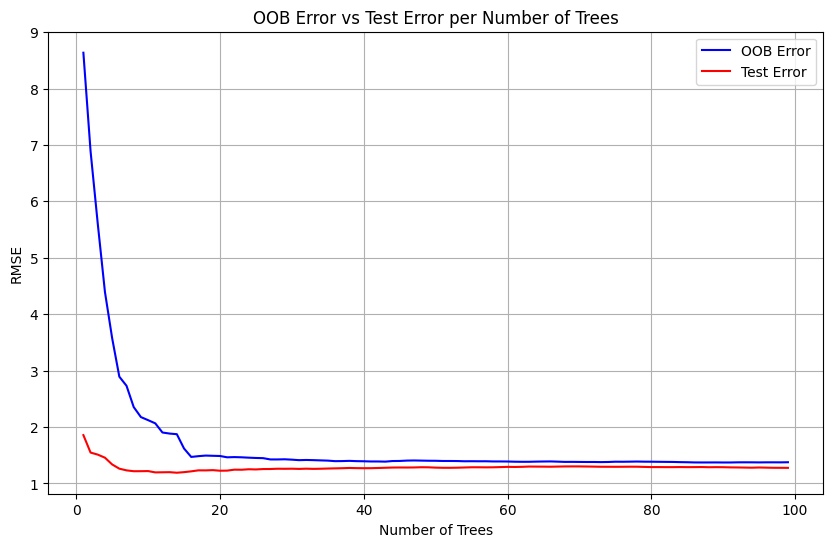

In [73]:
from sklearn.ensemble import RandomForestRegressor

n_estimators_range = range(1, 100)
oob_errors = []
test_errors = []

for n_estimators in n_estimators_range:
  rf = RandomForestRegressor(n_estimators = n_estimators, oob_score = True, random_state = 1)
  rf.fit(X_train, y_train)

  oob_error = np.sqrt(mean_squared_error(y_train, rf.oob_prediction_))
  oob_errors.append(oob_error)

  y_pred = rf.predict(X_test)
  test_error = np.sqrt(mean_squared_error(y_test, y_pred))
  test_errors.append(test_error)

error_df = pd.DataFrame({
    'n_estimators': n_estimators_range,
    'OOB Error': oob_errors,
    'Test Error': test_errors
})

plt.figure(figsize=(10, 6))
plt.plot(error_df['n_estimators'], error_df['OOB Error'], label='OOB Error', color='blue')
plt.plot(error_df['n_estimators'], error_df['Test Error'], label='Test Error', color='red')
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('OOB Error vs Test Error per Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
rf = RandomForestRegressor(oob_score = True, n_estimators = 80)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_MSE = mean_squared_error(y_test, rf_pred)
print(np.round(np.sqrt(rf_MSE), 3))

1.329


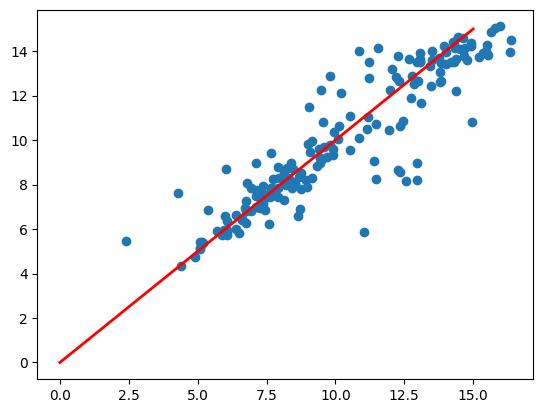

In [75]:
plt.scatter(y_test, rf_pred)
plt.plot([0, 15], [0, 15], color='red', linewidth=2)

plt.show()

###Boosting: XGBoost

In [76]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, plot_importance

param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'n_estimators': [100, 200, 300, 400, 500]
}

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

xgb_reg = grid_search.best_estimator_
xgb_pred = xgb_reg.predict(X_test)
xgb_RMSE = np.sqrt(mean_squared_error(y_test, xgb_pred))

print('Best parameters:', grid_search.best_params_)
print('Best RMSE:', np.round(xgb_RMSE, 3))

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Best RMSE: 1.325


In [77]:
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse', learning_rate = 0.05, max_depth = 3, n_estimators = 500)
xgb_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
xgb_RMSE = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(np.round(xgb_RMSE, 3))

1.325


##Stacking

In [78]:
from sklearn.model_selection import KFold

final_ridge = Ridge()

kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

oof_pred_linear = np.zeros(X_train.shape[0])
oof_pred_ridge = np.zeros(X_train.shape[0])
oof_pred_lasso = np.zeros(X_train.shape[0])
oof_pred_elastic = np.zeros(X_train.shape[0])
oof_pred_rf = np.zeros(X_train.shape[0])
oof_pred_xgb = np.zeros(X_train.shape[0])

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    linear.fit(X_train_fold, y_train_fold)
    ridge.fit(X_train_fold, y_train_fold)
    lasso.fit(X_train_fold, y_train_fold)
    elastic_net.fit(X_train_fold, y_train_fold)
    rf.fit(X_train_fold, y_train_fold)
    xgb_reg.fit(X_train_fold, y_train_fold)

    oof_pred_linear[val_index] = linear.predict(X_val_fold)
    oof_pred_ridge[val_index] = linear.predict(X_val_fold)
    oof_pred_lasso[val_index] = linear.predict(X_val_fold)
    oof_pred_elastic[val_index] = linear.predict(X_val_fold)
    oof_pred_rf[val_index] = linear.predict(X_val_fold)
    oof_pred_xgb[val_index] = linear.predict(X_val_fold)

X_train_final = np.column_stack((oof_pred_linear, oof_pred_ridge, oof_pred_lasso, oof_pred_elastic, oof_pred_rf, oof_pred_xgb))
final_ridge.fit(X_train_final, y_train)

X_test_pred_linear = linear.predict(X_test)
X_test_pred_ridge = ridge.predict(X_test)
X_test_pred_lasso = lasso.predict(X_test)
X_test_pred_elastic = elastic_net.predict(X_test)
X_test_pred_rf = rf.predict(X_test)
X_test_pred_xgb = xgb_reg.predict(X_test)

X_test_final = np.column_stack((X_test_pred_linear, X_test_pred_ridge, X_test_pred_lasso, X_test_pred_elastic, X_test_pred_rf, X_test_pred_xgb))
final_pred = final_ridge.predict(X_test_final)

final_RMSE = np.sqrt(mean_squared_error(y_test, final_pred))
print(np.round(final_RMSE, 3))

1.325


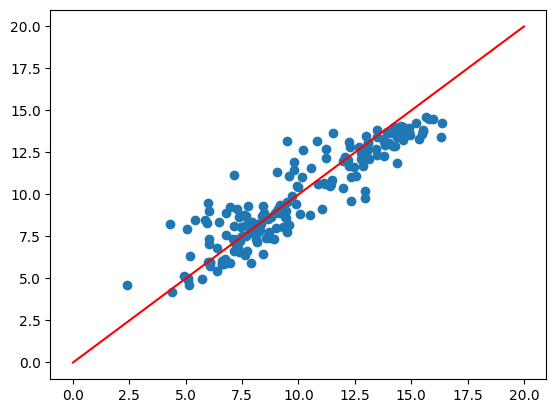

In [79]:
plt.scatter(y_test, final_pred)
plt.plot([0, 20], [0, 20], color = 'red')

plt.show()

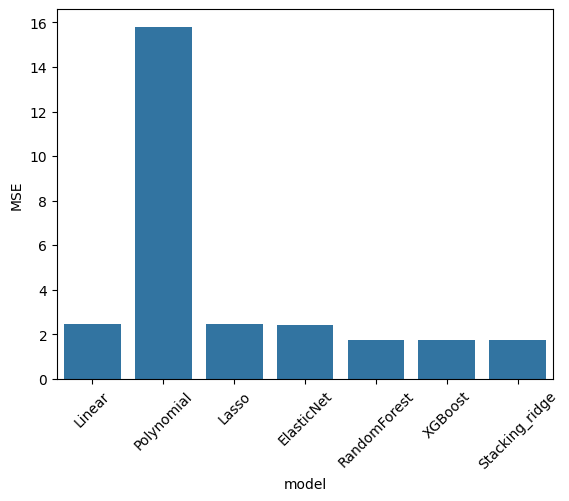

In [80]:
MSEs = pd.DataFrame({'model': ['Linear', 'Polynomial', 'Lasso', 'ElasticNet', 'RandomForest', 'XGBoost', 'Stacking_ridge'],
                     'MSE': [linear_MSE, poly_MSE, lasso_MSE, elastic_MSE, rf_MSE, xgb_RMSE **2, final_RMSE ** 2]})

sns.barplot(x = 'model', y = 'MSE', data = MSEs)
plt.xticks(rotation = 45)
plt.show()

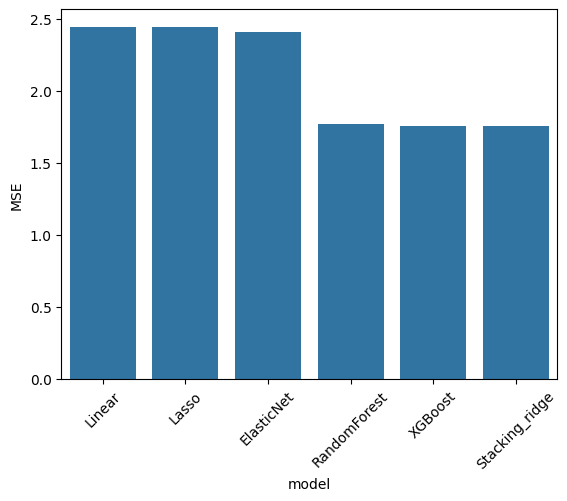

In [81]:
MSEs = pd.DataFrame({'model': ['Linear', 'Lasso', 'ElasticNet', 'RandomForest', 'XGBoost', 'Stacking_ridge'],
                     'MSE': [linear_MSE, lasso_MSE, elastic_MSE, rf_MSE, xgb_RMSE **2, final_RMSE ** 2]})

sns.barplot(x = 'model', y = 'MSE', data = MSEs)
plt.xticks(rotation = 45)
plt.show()

## Voting

In [82]:
import numpy as np
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import accuracy_score

In [83]:
model_preds = np.array([rf_pred, xgb_pred, final_pred])

weights = np.array([0.4, 0.3, 0.3])

voting_pred = np.average(model_preds, axis=0, weights=weights)

voting_MSE = mean_squared_error(y_test, voting_pred)
voting_MSE

1.4934834085303998

In [84]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [85]:
def stepwise_selection(X, y, direction='both', significance_level=0.05):
    initial_features = X.columns.tolist()
    best_features = initial_features.copy()
    while True:
        changed = False
        if direction in ['both', 'backward']:
            model = sm.OLS(y, sm.add_constant(X[best_features])).fit()
            p_values = model.pvalues.iloc[1:]  # const 제외
            max_p_value = p_values.max()
            if max_p_value > significance_level:
                changed = True
                feature_to_remove = p_values.idxmax()
                best_features.remove(feature_to_remove)
                print(f"Removed {feature_to_remove} with p-value {max_p_value:.4f}")

        if direction in ['both', 'forward']:
            remaining_features = list(set(initial_features) - set(best_features))
            for feature in remaining_features:
                model = sm.OLS(y, sm.add_constant(X[best_features + [feature]])).fit()
                p_value = model.pvalues[feature]
                if p_value < significance_level:
                    changed = True
                    best_features.append(feature)
                    print(f"Added {feature} with p-value {p_value:.4f}")
                    break  # Add only one feature at a time

        if not changed:
            break

    return best_features

# Stepwise Selection 적용
selected_features = stepwise_selection(X_train, y_train, direction='both')

# 선택된 특성으로 모델 학습
X_train_selected = X_train[selected_features]
model = LinearRegression()
model.fit(X_train_selected, y_train)

# 예측
y_pred = model.predict(X_test[selected_features])

# 성능 평가
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')

Removed genre_10 with p-value 0.9041
Removed genre_11 with p-value 0.9273
Removed genre_6 with p-value 0.8452
Removed genre_5 with p-value 0.6510
Removed genre_2 with p-value 0.6402
Removed genre_9 with p-value 0.4880
Removed genre_8 with p-value 0.4926
Removed genre_0 with p-value 0.4121
Removed genre_3 with p-value 0.2993
Removed dir_prev_num with p-value 0.2003
Removed genre_1 with p-value 0.2041
Removed num_actor with p-value 0.1412
Removed genre_7 with p-value 0.1276
Mean Squared Error: 2.4967


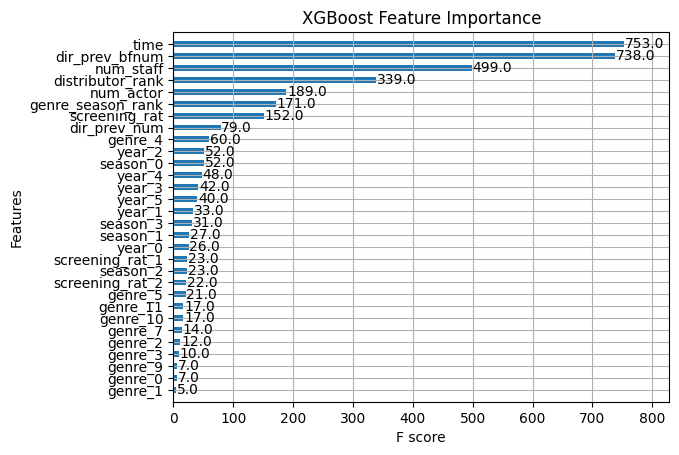

Mean Squared Error (Top 5 Features): 1.9816


In [86]:
import xgboost as xgb
import matplotlib.pyplot as plt

# XGBoost 모델 학습
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=100)
xgb_reg.fit(X_train, y_train)

# XGBoost Feature Importance 시각화
xgb.plot_importance(xgb_reg, importance_type='weight', title='XGBoost Feature Importance', height=0.5)
plt.show()

# 상위 n개 특성 선택 (예: 상위 5개 특성)
top_n = 5
feature_importance = xgb_reg.feature_importances_
top_features = X_train.columns[np.argsort(feature_importance)[-top_n:]]  # 상위 n개 특성

# 상위 n개 특성으로 모델 학습
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

xgb_top = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=100)
xgb_top.fit(X_train_top, y_train)

# 예측
y_pred_top = xgb_top.predict(X_test_top)

# 성능 평가
print(f'Mean Squared Error (Top {top_n} Features): {mean_squared_error(y_test, y_pred_top):.4f}')


#Submission

In [87]:
# 파일을 읽고 'index' 열을 데이터프레임의 인덱스로 설정
submission = pd.read_csv("/content/drive/MyDrive/미니 프로젝트 3/submission.csv", sep=',')

voting

In [88]:
rf = RandomForestRegressor(oob_score = True, n_estimators = 80)
xgb = XGBRegressor(objective = 'reg:squarederror', eval_metric = 'rmse', learning_rate = 0.05, max_depth = 3, n_estimators = 500)

rf.fit(X, y)
xgb.fit(X, y)

rf_pred = rf.predict(test_df)
xgb_pred = xgb.predict(test_df)

In [89]:
from sklearn.model_selection import KFold

final_ridge = Ridge()

kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

oof_pred_linear = np.zeros(X.shape[0])
oof_pred_ridge = np.zeros(X.shape[0])
oof_pred_lasso = np.zeros(X.shape[0])
oof_pred_elastic = np.zeros(X.shape[0])
oof_pred_rf = np.zeros(X.shape[0])
oof_pred_xgb = np.zeros(X.shape[0])

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    linear.fit(X_train_fold, y_train_fold)
    ridge.fit(X_train_fold, y_train_fold)
    lasso.fit(X_train_fold, y_train_fold)
    elastic_net.fit(X_train_fold, y_train_fold)
    rf.fit(X_train_fold, y_train_fold)
    xgb_reg.fit(X_train_fold, y_train_fold)

    oof_pred_linear[val_index] = linear.predict(X_val_fold)
    oof_pred_ridge[val_index] = linear.predict(X_val_fold)
    oof_pred_lasso[val_index] = linear.predict(X_val_fold)
    oof_pred_elastic[val_index] = linear.predict(X_val_fold)
    oof_pred_rf[val_index] = linear.predict(X_val_fold)
    oof_pred_xgb[val_index] = linear.predict(X_val_fold)

X_train_final = np.column_stack((oof_pred_linear, oof_pred_ridge, oof_pred_lasso, oof_pred_elastic, oof_pred_rf, oof_pred_xgb))
final_ridge.fit(X_train_final, y)

X_test_pred_linear = linear.predict(test_df)
X_test_pred_ridge = ridge.predict(test_df)
X_test_pred_lasso = lasso.predict(test_df)
X_test_pred_elastic = elastic_net.predict(test_df)
X_test_pred_rf = rf.predict(test_df)
X_test_pred_xgb = xgb_reg.predict(test_df)

X_test_final = np.column_stack((X_test_pred_linear, X_test_pred_ridge, X_test_pred_lasso, X_test_pred_elastic, X_test_pred_rf, X_test_pred_xgb))
final_pred = final_ridge.predict(X_test_final)

In [90]:
print(rf_pred.shape)
print(xgb_pred.shape)
print(final_pred.shape)


(243,)
(243,)
(243,)


In [91]:
model_preds = np.array([rf_pred, xgb_pred, final_pred])

weights = np.array([0.4, 0.3, 0.3])

voting_pred = np.average(model_preds, axis=0, weights=weights)

submission_voting = submission.copy()
submission_voting['box_off_num'] = np.exp(voting_pred)
submission_voting.to_csv('submission_voting.csv', index=False)

submission_rf = submission.copy()
submission_rf['box_off_num'] = np.exp(rf_pred)
submission_rf.to_csv('submissioin_rf.csv', index = False)

submission_xgb = submission.copy()
submission_xgb['box_off_num'] = np.exp(xgb_pred)
submission_xgb.to_csv('submission_xgb.csv', index = False)

submission_stacking = submission.copy()
submission_stacking['box_off_num'] = np.exp(final_pred)
submission_stacking.to_csv('submission_stacking.csv', index = False)